In [1]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import csv
import pickle
import random
import cv2

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
import tensorflow.keras as keras
from tensorflow.math import confusion_matrix



from scipy import ndimage

In [2]:
# DCM Series Number extraction for CT_SCANS images from csv file

series = []

with open('/Users/langletmaxime/Desktop/ProstateX/ProstateX-TrainingLesionInformationv2/ProstateX-Images-Train.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        #print(', '.join(row))
        if row[-2][-3:] == 'tra':
            series.append([row[0], row[2], row[3], row[-9], row[-2],row[-1]])


series = sorted(series, key=lambda x: (x[0],x[1]))

print(np.asarray(series).shape)
print(series)

(413, 6)
[['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '167 224 9', 't2_tse_tra', '4'], ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', '157 186 10', 't2_tse_tra', '6'], ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', '157 186 10', 't2_tse_tra', '10'], ['ProstateX-0002', '1', '-27.0102 41.5467 -26.0469', '154 217 12', 't2_tse_tra', '4'], ['ProstateX-0002', '2', '-2.058 38.6752 -34.6104', '203 216 10', 't2_tse_tra', '4'], ['ProstateX-0003', '1', '22.1495 31.2717 -2.45933', '240 205 12', 't2_tse_tra', '3'], ['ProstateX-0003', '2', '-21.2871 19.3995 19.7429', '153 161 17', 't2_tse_tra', '3'], ['ProstateX-0004', '1', '-7.69665 3.64226 23.1659', '221 168 7', 't2_tse_tra', '5'], ['ProstateX-0005', '0', '-14.5174331665039 49.4428329467773 20.7815246582031', '206 233 10', 't2_tse_tra', '4'], ['ProstateX-0005', '1', '-22.0892639160156 25.4668045043945 22.8791542053223', '190 185 10', 't2_tse_tra', '4'], ['ProstateX-0005', '1', 

In [3]:
# True or false extraction for ADC images from csv file

clinsig = []

with open('/Users/langletmaxime/Desktop/ProstateX/ProstateX-TrainingLesionInformationv2/ProstateX-Findings-Train.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        clinsig.append([row[0],row[1], row[2], row[-1]])
    clinsig.remove(clinsig[0])

clinsig2 = clinsig
#for n in range(len(clinsig)):
    #print(n, clinsig[n])
    
cp = []
cl = clinsig.copy()
j=0
n=0
seen = []

while j != len(series):
    if clinsig[n][0] == series[j][0] and clinsig[n][1] == series[j][1] and clinsig[n][2] == series[j][2]:
        if clinsig[n] not in seen:
            cp.append([clinsig[n], series[j]])
            seen.append(clinsig[n])
        j+=1
    n+=1
    if n == len(clinsig):
        n=0

print(clinsig)
print(len(clinsig))
cp.remove(cp[307])

[['ProstateX-0000', '1', '25.7457 31.8707 -38.511', 'TRUE'], ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', 'FALSE'], ['ProstateX-0002', '1', '-27.0102 41.5467 -26.0469', 'TRUE'], ['ProstateX-0002', '2', '-2.058 38.6752 -34.6104', 'FALSE'], ['ProstateX-0003', '1', '22.1495 31.2717 -2.45933', 'FALSE'], ['ProstateX-0003', '2', '-21.2871 19.3995 19.7429', 'FALSE'], ['ProstateX-0004', '1', '-7.69665 3.64226 23.1659', 'FALSE'], ['ProstateX-0005', '0', '-14.5174331665039 49.4428329467773 20.7815246582031', 'TRUE'], ['ProstateX-0005', '1', '-38.6276 42.2781 21.4084', 'TRUE'], ['ProstateX-0005', '1', '-22.0892639160156 25.4668045043945 22.8791542053223', 'FALSE'], ['ProstateX-0006', '1', '8.20024 28.2665 -10.4784', 'FALSE'], ['ProstateX-0006', '2', '-9.85971 37.2739 0.561445', 'FALSE'], ['ProstateX-0007', '1', '-5.4258 20.1075 -57.34', 'FALSE'], ['ProstateX-0008', '1', '25.2302 38.6613 -26.864', 'FALSE'], ['ProstateX-0009', '1', '19.565 32.8037 -37.4421', 'FALSE

In [4]:
series = []
clinsig = []
for i in range(0,len(cp)):
    clinsig.append(cp[i][0])
    series.append(cp[i][1])
    

    
print(len(series), len(clinsig), series[0])

328 328 ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '167 224 9', 't2_tse_tra', '4']


In [5]:
# file filter from preceding listing



import os
def directory_find(atom, root, series):
    for path, dirs, files in os.walk(root):
        if atom in files:
            seriesPath = os.path.join(path, atom).split('/')
            tempPath = os.path.join(path,atom)
            if seriesPath[-2][0] == series[n][-1]  and seriesPath[-2][1] == ".":
                return tempPath[:-8]
            if seriesPath[-2][0:2] == series[n][-1] and seriesPath[-2][2] == ".":
                return tempPath[:-8]

            
paths = []
for n in range(len(series)):
    paths.append(directory_find('1-01.dcm','/Users/langletmaxime/Desktop/ProstateX/PROSTATEx/'+series[n][0], series))
print(len(paths))

328


In [6]:
#exctracting coeficients ijk

ijk = []
for n in range(len(series)):
    temp2 = []
    temp = series[n][3].split(' ')
    temp = np.asarray(temp)
    temp2.append([temp[0].astype(int), temp[1].astype(int), temp[2].astype(int)])
    ijk.append(temp2[0])

    
print(len(ijk))

328


In [7]:
# File storing into an array and sorted out

def file_storing(root):
    files_stored = []
    for path, dirs, files in os.walk(root):
        files = sorted(files, key = lambda x: x[:-4])
        for file in files:
            ds = dicom.dcmread(path+file)
            files_stored.append(ds)
    return files_stored

  
files_stored = []

for n in range(len(paths)):
    try:
        files_stored.append(file_storing(paths[n]))
    except TypeError:
        print(n)
        j=n

ijk.remove(ijk[j])
clinsig.remove(clinsig[j])
    
print(len(files_stored), len(ijk))

182
327 327


In [8]:
# rectifying problem with k = 25 and k<0
# necessary if not prbm later
cp = []
for n in range(len(ijk)):
    if (ijk[n][2] < 0 or ijk[n][2] > len(files_stored[n])):
        print(n, ijk[n])
        cp.append(n)


i=0
for n in cp:
    ijk.remove(ijk[n-i])
    files_stored.remove(files_stored[n-i])
    series.remove(series[n-i])
    clinsig.remove(clinsig[n-i])
    i+=1

print(len(files_stored), len(ijk), len(series), len(clinsig))

34 [266, 200, 26]
229 [201, 162, 23]
230 [149, 206, 24]
324 324 325 324


In [9]:
# so we only have an array of picture and not dicom files then to gray scale 

for n in range(len(files_stored)):
    for i in range(len(files_stored[n])):
        files_stored[n][i] = files_stored[n][i].pixel_array
        files_stored[n][i] = files_stored[n][i].astype(float)
        files_stored[n][i] = (np.maximum(files_stored[n][i],0) / files_stored[n][i].max()) * 255.0
        files_stored[n][i] = np.uint8(files_stored[n][i])

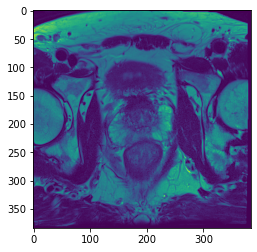

In [11]:
plt.imshow(files_stored[0][9])
plt.savefig("pic/example_T2.png")

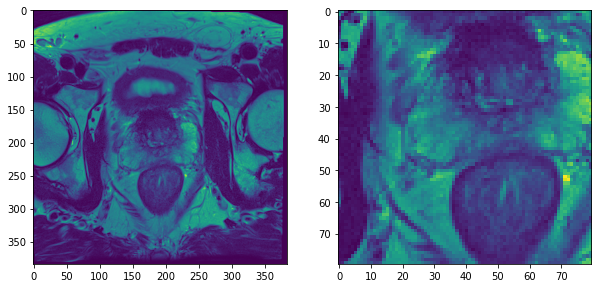

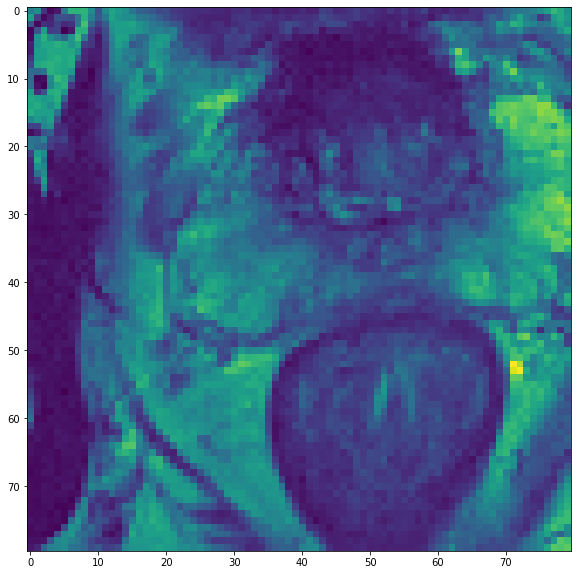

(80, 80)
(80, 80)


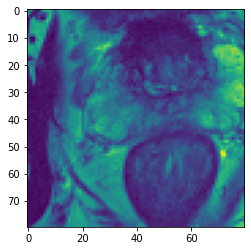

In [11]:
files_stored2 = []



size = 80


pic2 = files_stored[0][ijk[0][2]-1][ijk[0][1]-80:ijk[0][1]+80, ijk[0][0]-80:ijk[0][0]+80]
pic = files_stored[0][ijk[0][2]-1][:,:]
pic2 = cv2.resize(pic2,(size, size))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(pic)
plt.subplot(1,2,2)
plt.imshow(pic2)
plt.savefig('pic/T2_ex.png')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(pic2)
plt.savefig('pic/T2_crop.png')
plt.show()

for i in range(len(files_stored)):
    x, y = ijk[i][0], ijk[i][1]
    pic = files_stored[i][ijk[i][2]-1][ijk[i][1]-size:ijk[i][1]+size, ijk[i][0]-size:ijk[i][0]+size]
    pic = cv2.resize(pic,(size,size))
    files_stored2.append(pic)
print(np.asarray(files_stored2[0]).shape)# dimensions ok with all the corrections. 
    
#plt.imshow(files_stored2[0])
print(np.asarray(files_stored2[0]).shape)# dimensions ok with all the corrections. 
plt.figure()
plt.imshow(files_stored2[0])
plt.show()


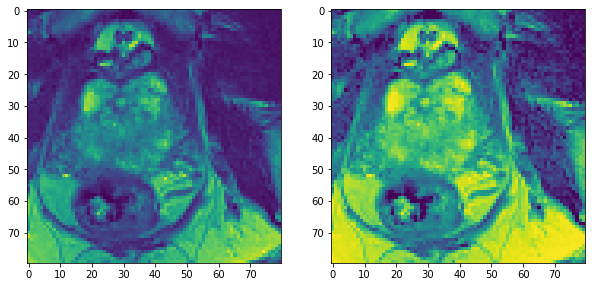

In [12]:
def equalize(im):   
    hist = np.histogram(im, bins=np.arange(257))[0] 
    c_hist = np.zeros((256,))
    c=0
    for j in range(256):
        c += hist[j]
        c_hist[j] = c
    # Normalize to 0-255 range & convert to integer
    lut_eq = (255*c_hist/c_hist.max()).astype('int')
    im_eq = lut_eq[im]
    return im_eq
pic2 = equalize(pic)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(pic)
plt.subplot(1,2,2)
plt.imshow(pic2)
plt.savefig('pic/T2_eq.png')
plt.show()

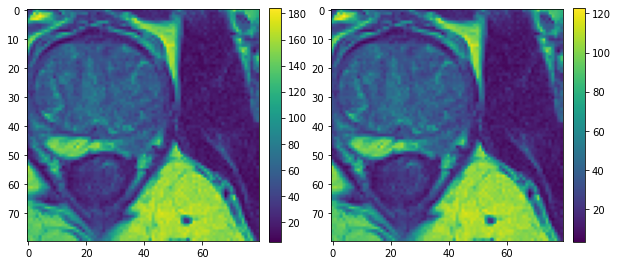

In [27]:
plt.figure(figsize=(10,10))
pic2=pic/1.5
plt.subplot(1,2,1)
plt.imshow(pic)
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1,2,2)
plt.imshow(pic2)
plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('pic/T2_bright.png')
plt.show()

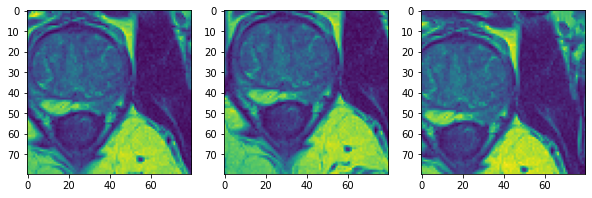

In [17]:
i=10
ijk2=ijk
shiftx=10
shifty=-10

pic = files_stored[i][ijk2[i][2]-1][ijk2[i][1]-size:ijk2[i][1]+size, ijk2[i][0]-size:ijk2[i][0]+size]
#print(pic.shape)
pic = cv2.resize(pic,(size, size))

pic2 = files_stored[i][ijk2[i][2]-1][ijk2[i][1]-size+shiftx:ijk[i][1]+size+shiftx, ijk2[i][0]-size+shifty:ijk2[i][0]+size+shifty]
pic2 = cv2.resize(pic2,(size, size))

pic3 = files_stored[i][ijk2[i][2]-1][ijk2[i][1]-size-shiftx:ijk2[i][1]+size-shiftx, ijk2[i][0]-size-shifty:ijk2[i][0]+size-shifty]
#print(pic2.shape)
pic3 = cv2.resize(pic3,(size, size))



plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(pic)
plt.subplot(1,3,2)
plt.imshow(pic2)
plt.subplot(1,3,3)
plt.imshow(pic3)
plt.savefig('pic/T2_shift.png')
plt.show()

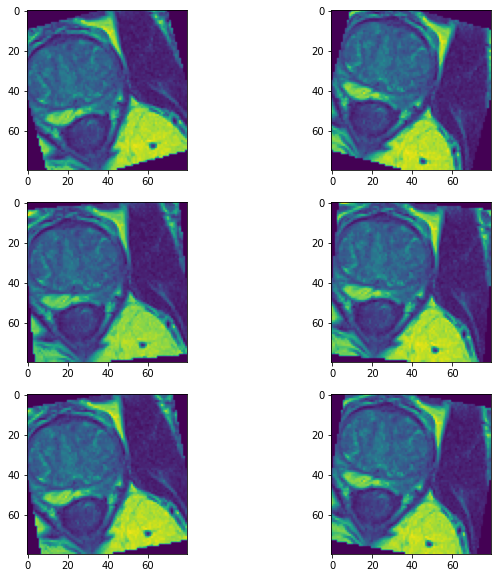

In [29]:
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.imshow(ndimage.rotate(pic, 15, reshape=False))
plt.subplot(3,2,2)
plt.imshow(ndimage.rotate(pic, -15, reshape=False))
plt.subplot(3,2,3)
plt.imshow(ndimage.rotate(pic, 5, reshape=False))
plt.subplot(3,2,4)
plt.imshow(ndimage.rotate(pic, -5, reshape=False))
plt.subplot(3,2,5)
plt.imshow(ndimage.rotate(pic, 10, reshape=False))
plt.subplot(3,2,6)
plt.imshow(ndimage.rotate(pic, -10, reshape=False))
plt.savefig('pic/T2_rot.png')
plt.show()

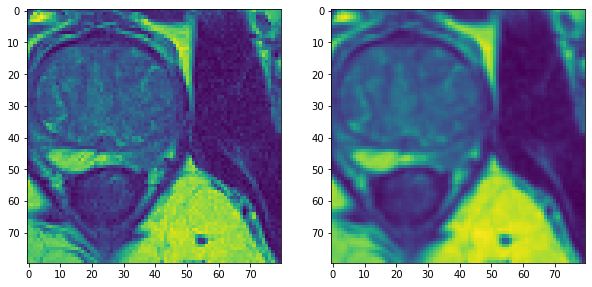

In [30]:
ndimage.gaussian_filter(pic, sigma=0.7)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(pic)
plt.subplot(1,2,2)
plt.imshow(ndimage.gaussian_filter(pic, sigma=0.7))
plt.savefig('pic/T2_gauss.png')
plt.show()

In [124]:
#ATTENTION: CNN not really DNN see real difference

batch_size = 32
img_height = size # 80
img_width = size # 80

#for now we are not going to test the training on the test database

In [125]:
final = np.zeros((len(files_stored),img_height,img_width,1))

for n in range(len(files_stored2)):
    for i in range(len(files_stored2[0])):
        for j in range(len(files_stored2[0])):
            final[n][i][j][0] = files_stored2[n][i][j]
print(final.shape)

category = []
training_data = []
j=0
for i in range(len(clinsig)):
    if clinsig[i][3] == "TRUE":
        category.append([1,0])
    else:
        category.append([0,1])
        j +=1
print(len(category), j)#  we have a biais, keep in mind 

for k in range(len(category)):
    training_data.append([final[k], category[k]])
#print(test_data[0])

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

#print(X[0].reshape(-1, img_height, img_width, 1))
X = np.array(X).reshape(-1, img_height, img_width, 1)

y= np.asarray(y)

(324, 80, 80, 1)
324 251


In [126]:
#nmbre for splitting test patients from training patients
nbr = 254


seed = np.random.randint(0, 10000)
np.random.seed(seed)
np.random.shuffle(X)
np.random.seed(seed)
np.random.shuffle(y)

np.random.seed(seed)
np.random.shuffle(files_stored)

np.random.seed(seed)
np.random.shuffle(clinsig)

np.random.seed(seed)
np.random.shuffle(ijk)

In [127]:
X_test = X[nbr:]
X_test = X_test/255.0
y_test = y[nbr:]

nbr -=70
X_val = X[nbr:nbr+70]
y_val = y[nbr:nbr+70]

X_save = X[:nbr]
y_save = y[:nbr]

print(len(X_val), len(X_test), nbr)
print(y_val)

70 70 184
[[1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]]


In [128]:
def equalize(im):   
    hist = np.histogram(im, bins=np.arange(257))[0] 
    c_hist = np.zeros((256,))
    c=0
    for j in range(256):
        c += hist[j]
        c_hist[j] = c
    # Normalize to 0-255 range & convert to integer
    lut_eq = (255*c_hist/c_hist.max()).astype('int')
    im_eq = lut_eq[im]
    return im_eq

In [129]:
def data_augmentation(files_stored_ct, clinsig, ijk2, resize):
    # Data augmentation
    data_augmented_ct = []
    category_augmented_ct = []
    training_data_augmented_ct = []
    ones=0
    zeros=0

    if resize:
        shiftx = 10
        shifty = -10
    else:
        shiftx = 5
        shifty = -5

    for i in range(len(files_stored_ct[:nbr])):
        #x, y = ijk[i][0], ijk[i][1]
        if clinsig[i][3] == "TRUE":
            #biasing problem
            category_augmented_ct.append(np.asarray([1,0]))#category_augmented.append([0,1])
            if resize:
                pic = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-size:ijk2[i][1]+size, ijk2[i][0]-size:ijk2[i][0]+size]
                #print(pic.shape)
                pic = cv2.resize(pic,(size, size))
            else:
                pic = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-20:ijk2[i][1]+20, ijk2[i][0]-20:ijk2[i][0]+20]
                pic = cv2.resize(pic,(size, size))
            data_augmented_ct.append(pic)
            ones +=1

            category_augmented_ct.append(np.asarray([1,0]))
            if resize:
                pic2 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-size+shiftx:ijk[i][1]+size+shiftx, ijk2[i][0]-size+shifty:ijk2[i][0]+size+shifty]
                pic2 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-size:ijk2[i][1]+size, ijk2[i][0]-size:ijk2[i][0]+size]
                #print(pic2.shape)
                pic2 = cv2.resize(pic2,(size, size))
            else:
                pic2 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-20+shiftx:ijk2[i][1]+20+shiftx, ijk2[i][0]-20+shifty:ijk2[i][0]+20+shifty]
                pic2 = cv2.resize(pic2,(size, size))
            data_augmented_ct.append(pic2)
            ones +=1

            category_augmented_ct.append(np.asarray([1,0]))
            if resize:
                pic3 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-size-shiftx:ijk2[i][1]+size-shiftx, ijk2[i][0]-size-shifty:ijk2[i][0]+size-shifty]
                #print(pic2.shape)
                pic3 = cv2.resize(pic3,(size, size))
            else:
                pic3 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-20-shiftx:ijk2[i][1]+20-shiftx, ijk2[i][0]-20-shifty:ijk2[i][0]+20-shifty]
                pic3 = cv2.resize(pic3,(size, size))
            data_augmented_ct.append(pic3)
            ones +=1

            #category_augmented_ct.append(np.asarray([1,0]))
            #if resize:
                #pic4 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-size+shiftx:ijk2[i][1]+size+shiftx, ijk2[i][0]-size-shifty:ijk2[i][0]+size-shifty]
                #pic4 = cv2.resize(pic4,(80, 80))
            #else:
                #pic4 = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-20+shiftx:ijk2[i][1]+20+shiftx, ijk2[i][0]-20-shifty:ijk2[i][0]+20-shifty]
                #pic4 = cv2.resize(pic4,(80, 80))
            #data_augmented_ct.append(pic4)
            #ones +=1

            #dimming brightness
            category_augmented_ct.append(np.asarray([1,0]))
            pic6 = pic/1.25
            pic62 = pic2/1.25
            pic63 = pic3/1.25
            #pic64 = pic4/1.25
            data_augmented_ct.append(pic6)
            ones +=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(pic62)
            ones +=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(pic63)
            ones +=1
            #category_augmented_ct.append(np.asarray([1,0]))
            #data_augmented_ct.append(pic64)
            #ones +=1
            
            category_augmented_ct.append(np.asarray([1,0]))
            pic6 = pic/1.5
            pic62 = pic2/1.5
            pic63 = pic3/1.5
            #pic64 = pic4/1.5
            data_augmented_ct.append(pic6)
            ones +=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(pic62)
            ones +=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(pic63)
            ones +=1
            #category_augmented_ct.append(np.asarray([1,0]))
            #data_augmented_ct.append(pic64)
            #ones +=1
            
            category_augmented_ct.append(np.asarray([1,0]))
            pic6 = pic/1.1
            pic62 = pic2/1.1
            pic63 = pic3/1.1
            #pic64 = pic4/1.1
            data_augmented_ct.append(pic6)
            ones +=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(pic62)
            ones +=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(pic63)
            ones +=1
            #category_augmented_ct.append(np.asarray([1,0]))
            #data_augmented_ct.append(pic64)
            #ones +=1

            #Rotating
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic, 10, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic, -10, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic, 5, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic, -5, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic, -15, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic, 15, reshape=False))
            ones+=1

            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic2, 10, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic2, -10, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic2, 5, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic2, -5, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic2, -15, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic2, 15, reshape=False))
            ones+=1

            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic3, 10, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic3, -10, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic3, 5, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic3, -5, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic3, -15, reshape=False))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.rotate(pic3, 15, reshape=False))
            ones+=1
            
            #category_augmented_ct.append(np.asarray([1,0]))
            #data_augmented_ct.append(ndimage.rotate(pic4, 10, reshape=False))
            #ones+=1
            #category_augmented_ct.append(np.asarray([1,0]))
            #data_augmented_ct.append(ndimage.rotate(pic4, -10, reshape=False))
            #ones+=1
            #category_augmented_ct.append(np.asarray([1,0]))
            #data_augmented_ct.append(ndimage.rotate(pic4, 5, reshape=False))
            #ones+=1
            #category_augmented_ct.append(np.asarray([1,0]))
            #data_augmented_ct.append(ndimage.rotate(pic4, -5, reshape=False))
            #ones+=1
            #category_augmented_ct.append(np.asarray([1,0]))
            #data_augmented_ct.append(ndimage.rotate(pic4, -15, reshape=False))
            #ones+=1
            #category_augmented_ct.append(np.asarray([1,0]))
            #data_augmented_ct.append(ndimage.rotate(pic4, 15, reshape=False))
            #ones+=1
            
            #Contrast enhancement
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(equalize(pic))
            ones+=1

            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(equalize(pic2))
            ones+=1

            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(equalize(pic3))
            ones+=1
            
            
            #category_augmented_ct.append(np.asarray([1,0]))
            #data_augmented_ct.append(equalize(pic4))
            #ones+=1
            
            #Gaussian filter
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.gaussian_filter(pic, sigma=0.7))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.gaussian_filter(pic2, sigma=0.7))
            ones+=1
            category_augmented_ct.append(np.asarray([1,0]))
            data_augmented_ct.append(ndimage.gaussian_filter(pic3, sigma=0.7))
            ones+=1
            #category_augmented_ct.append(np.asarray([1,0]))
            #data_augmented_ct.append(ndimage.gaussian_filter(pic4, sigma=0.7))
            #ones+=1

        else:
            category_augmented_ct.append(np.asarray([0,1]))
            if resize:
                pic = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-size:ijk2[i][1]+size, ijk2[i][0]-size:ijk2[i][0]+size]
                pic = cv2.resize(pic,(size, size))
            else:
                pic = files_stored[i][ijk2[i][2]-1][ijk2[i][1]-20:ijk2[i][1]+20, ijk2[i][0]-20:ijk2[i][0]+20]
                pic = cv2.resize(pic,(size, size))
            data_augmented_ct.append(pic)
            zeros +=1

            
            #dimming brightness
            category_augmented_ct.append(np.asarray([0,1]))
            pic2 = pic/1.25
            data_augmented_ct.append(pic2)

            zeros +=1
            
            category_augmented_ct.append(np.asarray([0,1]))
            pic2 = pic/1.5
            data_augmented_ct.append(pic2)
            zeros +=1
            
            category_augmented_ct.append(np.asarray([0,1]))
            pic2 = pic/1.1
            data_augmented_ct.append(pic2)
            zeros +=1

            #Rotating
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(ndimage.rotate(pic, 10, reshape=False))
            zeros+=1
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(ndimage.rotate(pic, -10, reshape=False))
            zeros+=1
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(ndimage.rotate(pic, 5, reshape=False))
            zeros+=1
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(ndimage.rotate(pic, -5, reshape=False))
            zeros+=1
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(ndimage.rotate(pic, -15, reshape=False))
            zeros+=1
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(ndimage.rotate(pic, 15, reshape=False))
            zeros+=1

            #Contrast enhancement
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(equalize(pic))
            zeros+=1
            
            #Gaussian filter
            category_augmented_ct.append(np.asarray([0,1]))
            data_augmented_ct.append(ndimage.gaussian_filter(pic, sigma=0.7))
            zeros+=1
            
    return category_augmented_ct, data_augmented_ct, ones, zeros

In [130]:
category, data, on, zer = data_augmentation(files_stored, clinsig, ijk, True)

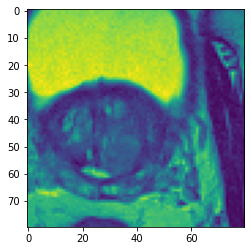

3192 3192 1476 1716


In [131]:
plt.figure()
plt.imshow(data[1])
plt.show()

category_augmented = category
data_augmented = data

print(len(data_augmented), len(category_augmented), on, zer)

In [132]:
print(np.asarray(data_augmented).shape)
final = np.zeros((np.asarray(data_augmented).shape[0],np.asarray(data_augmented).shape[1]
                  ,np.asarray(data_augmented).shape[2],1))

for n in range(len(data_augmented)):
    for i in range(len(data_augmented[0])):
        for j in range(len(data_augmented[0])):
            final[n][i][j][0] = data_augmented[n][i][j]
print(final.shape)

(3192, 80, 80)
(3192, 80, 80, 1)


In [133]:
training_data_augmented = []

for k in range(len(category_augmented)):
    training_data_augmented.append([final[k], category_augmented[k]])
    
random.shuffle(training_data_augmented)
print(len(training_data_augmented), k+1)
X = []
y = []

for features,label in training_data_augmented:
    X.append(features)
    y.append(label)

#print(X[0].reshape(-1, img_height, img_width, 1))
X = np.array(X).reshape(-1, img_height, img_width, 1)

y = np.asarray(y)

print(X.shape)

3192 3192
(3192, 80, 80, 1)


In [134]:
pickle_out = open("X_COR.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y_COR.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [135]:
pickle_in = open("X_COR.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y_COR.pickle","rb")
y = pickle.load(pickle_in)

y = np.asarray(y)

print(X.shape[1:])

(80, 80, 1)


In [136]:
pos=0
for i in range(len(y_val)):
    if y_val[i][0]==1:
        pos +=1 
print(pos/len(y_val))

0.22857142857142856


In [137]:
X=X/255.0
#random.shuffle(X)
print(X.shape)

(3192, 80, 80, 1)


In [138]:
from tensorflow.keras.layers import BatchNormalization

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)

filepath = "saved_model/best_weights"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [139]:
x_t=[]
y_t=[]
for i in range(len(X_val)):
    if y_val[i][0]==1:
        x_t.append(X_val[i])
        y_t.append(y_val[i])

n = len(x_t)*2
while len(y_t) <n:
    if y_val[i][0]==0:
        x_t.append(X_val[i])
        y_t.append(y_val[i])

x_t = np.array(x_t).reshape(-1, img_height, img_width, 1)
y_t = np.asarray(y_t)
np.random.seed(seed)
np.random.shuffle(x_t)
np.random.shuffle(y_t)
print(y_t)
print(np.asarray(y_t).shape, np.asarray(x_t).shape)

[[0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]
(32, 2) (32, 80, 80, 1)


In [142]:
#test

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]))#, kernel_initializer='he_uniform',
model.add(Dropout(0.3))
model.add(Conv2D(32, (3, 3), activation='relu'))#, kernel_initializer='he_uniform',
model.add(Dropout(0.3))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))


model.add(Conv2D(64, (3, 3), activation='relu'))#, kernel_initializer='he_uniform',
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu'))#, kernel_initializer='he_uniform',
model.add(Dropout(0.3))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(64, activation='relu'))#, kernel_initializer='he_uniform',

model.add(Dense(32, activation='relu'))#, kernel_initializer='he_uniform',

model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))
#opt=tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',#,loss='mse'
              optimizer='adam',
              #optimizer=opt,
              #metrics=[tf.keras.metrics.FalsePositives()])
              metrics=['accuracy'])

#history = model.fit(X, y, batch_size=16, epochs=30, validation_data=(X_val,y_val), shuffle=True,callbacks=[callback])#model_checkpoint_callback, 50, 
history = model.fit(X, y, batch_size=32, epochs=50, validation_data=(X_val,y_val), shuffle=True,callbacks=[model_checkpoint_callback])#,callbacks=[callback])#model_checkpoint_callback, 50, 

Epoch 1/50
100/100 [==============================] - 9s 86ms/step - loss: 0.7200 - accuracy: 0.5615 - val_loss: 9.1861 - val_accuracy: 0.4857
Epoch 2/50
100/100 [==============================] - 8s 81ms/step - loss: 0.9311 - accuracy: 0.6043 - val_loss: 109.7474 - val_accuracy: 0.4286
Epoch 3/50
100/100 [==============================] - 8s 81ms/step - loss: 0.8711 - accuracy: 0.7308 - val_loss: 88.9744 - val_accuracy: 0.6286
Epoch 4/50
100/100 [==============================] - 8s 81ms/step - loss: 0.9254 - accuracy: 0.7795 - val_loss: 348.7863 - val_accuracy: 0.6571
Epoch 5/50
100/100 [==============================] - 8s 83ms/step - loss: 2.0846 - accuracy: 0.8329 - val_loss: 1101.8971 - val_accuracy: 0.7857
Epoch 6/50
100/100 [==============================] - 8s 81ms/step - loss: 3.5573 - accuracy: 0.8422 - val_loss: 382.6418 - val_accuracy: 0.6714
Epoch 7/50
100/100 [==============================] - 9s 85ms/step - loss: 2.2694 - accuracy: 0.8833 - val_loss: 1331.7168 - val_acc

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


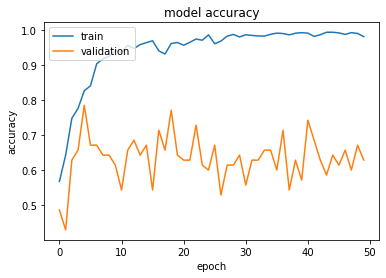

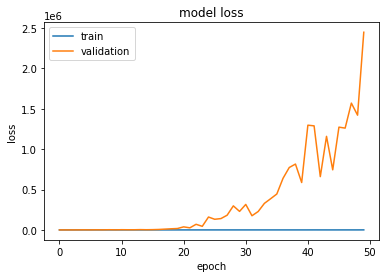

In [144]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('pic/model_history_COR_acc')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('pic/model_history_COR_loss')
plt.show()

In [146]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 78, 78, 32)        320       
_________________________________________________________________
dropout_107 (Dropout)        (None, 78, 78, 32)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 76, 76, 32)        9248      
_________________________________________________________________
dropout_108 (Dropout)        (None, 76, 76, 32)        0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
dropout_109 (Dropout)        (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 36, 36, 64)      

In [147]:
model.save('saved_model/COR_model')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: saved_model/COR_model/assets


In [110]:
#model = Sequential()
model = tf.keras.models.load_model('saved_model/COR_model')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 78, 78, 32)        320       
_________________________________________________________________
dropout_70 (Dropout)         (None, 78, 78, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 76, 76, 32)        9248      
_________________________________________________________________
dropout_71 (Dropout)         (None, 76, 76, 32)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 36, 36, 64)       

In [145]:
#model.evaluate(X[3500:],y[3500:])
model.evaluate(X_test,y_test)
predict = model.predict(X_test)

for i in range(len(predict)):
    print(predict[i], y_test[i])

3/3 [==============================] - 0s 20ms/step - loss: 24929.1172 - accuracy: 0.6571
[1. 0.] [0 1]
[0. 1.] [0 1]
[1. 0.] [0 1]
[0. 1.] [0 1]
[1. 0.] [1 0]
[0. 1.] [1 0]
[0. 1.] [0 1]
[1. 0.] [0 1]
[0. 1.] [0 1]
[0. 1.] [0 1]
[1. 0.] [1 0]
[1. 0.] [0 1]
[1. 0.] [0 1]
[0. 1.] [0 1]
[1. 0.] [0 1]
[1. 0.] [1 0]
[0. 1.] [0 1]
[1. 0.] [0 1]
[0. 1.] [0 1]
[1. 0.] [0 1]
[0. 1.] [0 1]
[0. 1.] [0 1]
[0. 1.] [0 1]
[0. 1.] [0 1]
[0. 1.] [0 1]
[0. 1.] [0 1]
[1. 0.] [1 0]
[1. 0.] [0 1]
[0. 1.] [0 1]
[1. 0.] [1 0]
[0. 1.] [0 1]
[0. 1.] [0 1]
[1. 0.] [0 1]
[0. 1.] [0 1]
[0. 1.] [0 1]
[0. 1.] [1 0]
[0. 1.] [0 1]
[0. 1.] [1 0]
[1. 0.] [1 0]
[0. 1.] [0 1]
[0. 1.] [0 1]
[0. 1.] [0 1]
[0. 1.] [0 1]
[0. 1.] [1 0]
[0. 1.] [1 0]
[0. 1.] [0 1]
[0. 1.] [0 1]
[0. 1.] [0 1]
[0. 1.] [1 0]
[0. 1.] [0 1]
[1. 0.] [0 1]
[0. 1.] [0 1]
[0. 1.] [0 1]
[0. 1.] [0 1]
[1. 0.] [0 1]
[0. 1.] [0 1]
[1. 0.] [0 1]
[0. 1.] [0 1]
[0. 1.] [0 1]
[0. 1.] [1 0]
[1. 0.] [1 0]
[0. 1.] [0 1]
[0. 1.] [1 0]
[1. 0.] [0 1]
[0. 1.] [0 1]


In [148]:
con = confusion_matrix(labels=y_test[:,0], predictions=predict[:,0]>0.5)
print(con)

tf.Tensor(
[[39 15]
 [ 9  7]], shape=(2, 2), dtype=int32)


In [149]:
pickle_out = open("X_COR_test.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("y_COR_test.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

pickle_in = open("X_COR_test.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in = open("y_COR_test.pickle","rb")
y_test = pickle.load(pickle_in)

y_test = np.asarray(y_test)

print(X_test.shape[:])

(70, 80, 80, 1)
